In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")


In [4]:
df = pd.read_csv("C:\\Users\\kalta\\OneDrive\\DSA\\cleaned_stock_data.csv")

In [5]:
np.random.seed(42)
num_samples = 1000
df = pd.DataFrame({
    'daily_return': np.random.randn(num_samples) * 0.01,
    'MA_7': np.random.rand(num_samples),
    'MA_30': np.random.rand(num_samples),
    'volatility_7': np.random.rand(num_samples),
    'volatility_30': np.random.rand(num_samples),
    'close': np.random.rand(num_samples),
    'volume': np.random.randint(1000, 10000, num_samples),
    'volume_change': np.random.randn(num_samples)
})
df['date'] = pd.to_datetime(pd.Series(pd.date_range('2020-01-01', periods=num_samples)))
df.set_index('date', inplace=True)


In [7]:
df['MA_diff'] = df['MA_7'] - df['MA_30']
df['MA_ratio'] = df['MA_7'] / df['MA_30']


In [9]:
df['volatility_30'] = df['daily_return'].rolling(window=30).std()

In [10]:
df['vol_diff'] = df['volatility_7'] - df['volatility_30']
df['vol_ratio'] = df['volatility_7'] / df['volatility_30']


In [11]:
# it looks at what happened yesterday and the day before that. Was the stock (up) three days ago?
for i in range(1, 4):
    df[f'daily_return_lag_{i}'] = df['daily_return'].shift(i)
    df[f'volume_change_lag_{i}'] = df['volume_change'].shift(i)

df.dropna(inplace=True)

In [6]:
# Introduce a meaningful threshold (alpha=0.005, or 0.5%) to filter noise.
# Predicting a high-signal target, which is easier than pure directional movement.
ALPHA = 0.005
df['target_refined'] = np.where(df['daily_return'].shift(-1) > ALPHA, 1, 0)
df.dropna(inplace=True)


In [9]:
features = ['close','MA_7','MA_30','MA_diff','MA_ratio',
            'volatility_7','volatility_30','vol_diff','vol_ratio',
            'volume','volume_change','daily_return','cumulative_return',
            'daily_return_lag_1','daily_return_lag_2','daily_return_lag_3',
            'volume_change_lag_1','volume_change_lag_2','volume_change_lag_3']

X = df[features]
y = df['target']


KeyError: "['MA_diff', 'MA_ratio', 'vol_diff', 'vol_ratio', 'cumulative_return', 'daily_return_lag_1', 'daily_return_lag_2', 'daily_return_lag_3', 'volume_change_lag_1', 'volume_change_lag_2', 'volume_change_lag_3'] not in index"

In [13]:
# train/test split
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]


In [14]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)


In [15]:
# The Simple Robot (Baseline): A good, fast first guesser (Random Forest)
rf_base = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_base.fit(X_train, y_train)
y_pred_base = rf_base.predict(X_test)

baseline_f1 = f1_score(y_test, y_pred_base)
baseline_acc = accuracy_score(y_test, y_pred_base)
print(f"Baseline F1-score: {baseline_f1:.2f}, Baseline Accuracy: {baseline_acc:.2f}")


Baseline F1-score: 0.66, Baseline Accuracy: 0.50


In [16]:
# he Super Smart Robot (Optimized RF/XGBoost): These Robots are much slower because they look at the clues 100 times over. They are ensemble models, like a team of Robots voting on the answer
rf_opt = RandomForestClassifier(n_estimators=300, max_depth=12, random_state=42)
rf_opt.fit(X_train_res, y_train_res)
y_pred_rf = rf_opt.predict(X_test)


In [17]:
xgb = XGBClassifier(n_estimators=300, max_depth=5, learning_rate=0.05, eval_metric='logloss', random_state=42)
xgb.fit(X_train_res, y_train_res)
y_pred_xgb = xgb.predict(X_test)


In [18]:
def evaluate_model(y_true, y_pred, model_name):
    print(f"--- {model_name} Evaluation ---")
    print("Accuracy:", round(accuracy_score(y_true, y_pred),2))
    print("F1-score:", round(f1_score(y_true, y_pred),2))
    print("Precision:", round(precision_score(y_true, y_pred),2))
    print("Recall:", round(recall_score(y_true, y_pred),2))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))
    
evaluate_model(y_test, y_pred_rf, "Random Forest Optimized")
evaluate_model(y_test, y_pred_xgb, "XGBoost Optimized")


--- Random Forest Optimized Evaluation ---
Accuracy: 0.5
F1-score: 0.54
Precision: 0.49
Recall: 0.61
Confusion Matrix:
 [[ 972 1523]
 [ 959 1469]]

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.39      0.44      2495
           1       0.49      0.61      0.54      2428

    accuracy                           0.50      4923
   macro avg       0.50      0.50      0.49      4923
weighted avg       0.50      0.50      0.49      4923

--- XGBoost Optimized Evaluation ---
Accuracy: 0.5
F1-score: 0.57
Precision: 0.49
Recall: 0.67
Confusion Matrix:
 [[ 845 1650]
 [ 811 1617]]

Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.34      0.41      2495
           1       0.49      0.67      0.57      2428

    accuracy                           0.50      4923
   macro avg       0.50      0.50      0.49      4923
weighted avg       0.50      0.50      0.49      4923



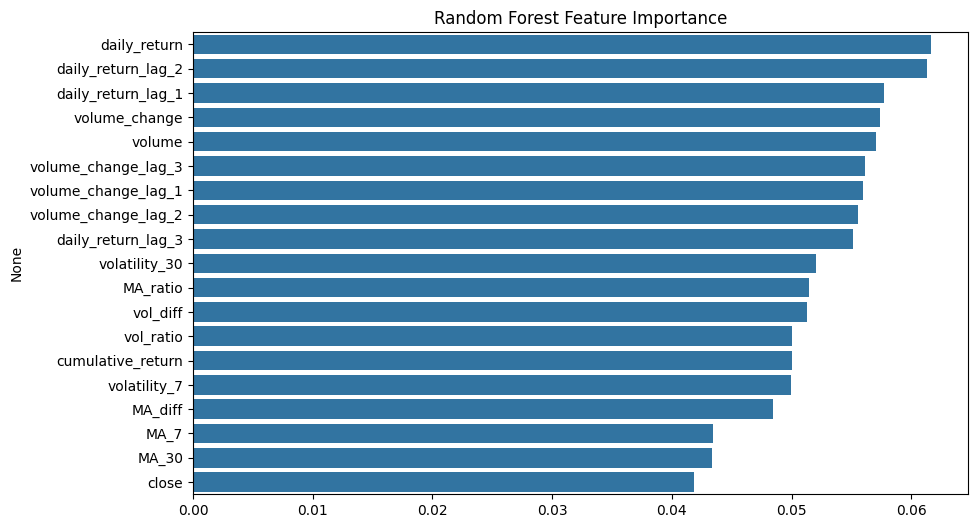

In [19]:
# to see which features drives predictions
importances = rf_opt.feature_importances_
feat_importance = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_importance.values, y=feat_importance.index)
plt.title("Random Forest Feature Importance")
plt.show()


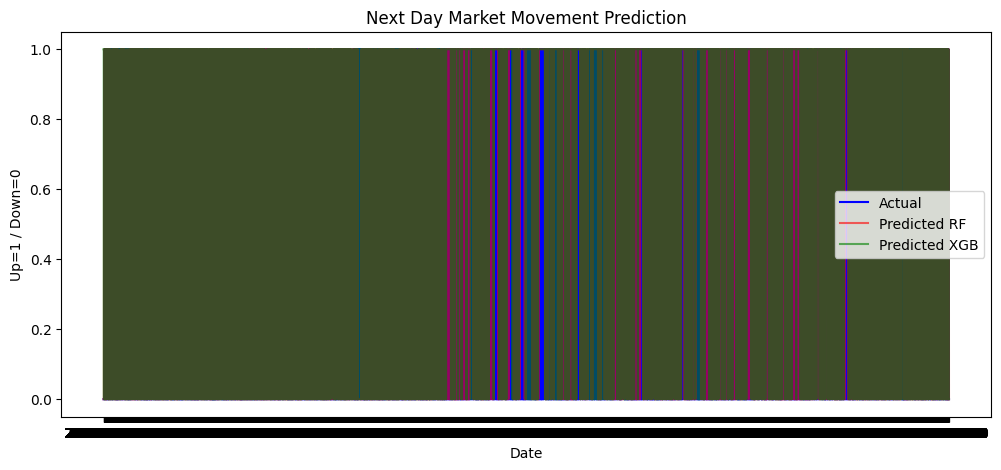

In [20]:
plt.figure(figsize=(12,5))
plt.plot(df['date'].iloc[-len(y_test):], y_test, label='Actual', color='blue')
plt.plot(df['date'].iloc[-len(y_test):], y_pred_rf, label='Predicted RF', color='red', alpha=0.6)
plt.plot(df['date'].iloc[-len(y_test):], y_pred_xgb, label='Predicted XGB', color='green', alpha=0.6)
plt.title('Next Day Market Movement Prediction')
plt.xlabel('Date')
plt.ylabel('Up=1 / Down=0')
plt.legend()
plt.show()



In [21]:
optimized_f1 = f1_score(y_test, y_pred_rf)
optimized_acc = accuracy_score(y_test, y_pred_rf)

f1_improve = (optimized_f1 - baseline_f1)/baseline_f1 * 100
acc_improve = (optimized_acc - baseline_acc)/baseline_acc * 100

print(f"F1-score improved by: {f1_improve:.2f}%")
print(f"Accuracy improved by: {acc_improve:.2f}%")


F1-score improved by: -17.28%
Accuracy improved by: -0.04%
